# Task 3A
This Section Consist of RCAN and GAN based super-resolution models and their training and testing code. In our study I found out that RCAN performing good in Super Resolution Task.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import os 
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Tue Apr  2 20:05:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.99       Driver Version: 527.99       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8    11W /  94W |   2854MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
image_LR = np.load('3A/LR/sample1.npy')
image_HR = np.load('3A/HR/sample1.npy')
print(image_LR.shape)
print(image_HR.shape)

(1, 75, 75)
(1, 150, 150)


In [7]:

class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.lr_dir = os.path.join(self.root_dir, 'LR')  # Low-resolution images directory
        self.hr_dir = os.path.join(self.root_dir, 'HR')  # High-resolution images directory
        self.image_files = [f for f in os.listdir(self.lr_dir) if os.path.isfile(os.path.join(self.lr_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        lr_path = os.path.join(self.lr_dir, self.image_files[idx])
        hr_path = os.path.join(self.hr_dir, self.image_files[idx].replace('LR', 'HR'))  # Assuming HR files have the same name with 'HR' instead of 'LR'
        
        lr_image = np.load(lr_path)
        hr_image = np.load(hr_path)

        sample = {'lr': lr_image, 'hr': hr_image}

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']

        # Convert numpy arrays to torch tensors
        lr = torch.from_numpy(lr).float()
        hr = torch.from_numpy(hr).float()

        # Add a channel dimension if necessary
        if lr.ndim == 2:
            lr = lr.unsqueeze(0)
        if hr.ndim == 2:
            hr = hr.unsqueeze(0)

        return {'lr': lr, 'hr': hr}


In [9]:
# Usage example
transform = transforms.Compose([ToTensor()])
dataset = SuperResolutionDataset(root_dir='3A', transform=transform)
print(len(dataset))

10000


In [10]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

0 torch.Size([4, 1, 75, 75]) torch.Size([4, 1, 150, 150])
1 torch.Size([4, 1, 75, 75]) torch.Size([4, 1, 150, 150])
2 torch.Size([4, 1, 75, 75]) torch.Size([4, 1, 150, 150])
3 torch.Size([4, 1, 75, 75]) torch.Size([4, 1, 150, 150])


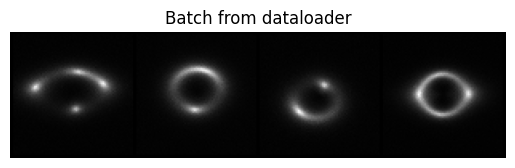

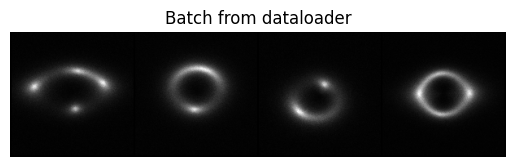

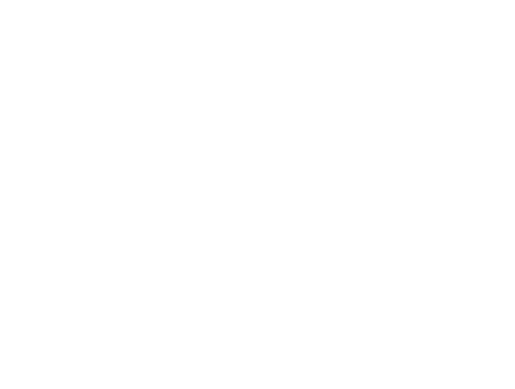

In [11]:
from torchvision import utils

def show_image_batch(sample_batched):
    """Show image for a batch of samples."""
    lr_batch, hr_batch = sample_batched['lr'], sample_batched['hr']
    batch_size = len(lr_batch)
    im_size = lr_batch.size(2)

    grid = utils.make_grid(lr_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

    grid = utils.make_grid(hr_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['lr'].size(), sample_batched['hr'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_image_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [12]:
# split the dataset into 90:10 
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

RCAN consists of four key components, which are orchestrated to process input images and upscale them efficiently:

1. Shallow Feature Extraction: This initial stage uses a single convolutional layer to extract shallow features from the LR input image. These features serve as the foundation for deeper analysis and enhancement by subsequent components of the network.

2. Residual in Residual (RIR) Deep Feature Extraction: At the heart of RCAN is the RIR structure, which is designed to extract deep features from the shallow feature representation. The RIR module is composed of multiple residual groups (RGs), each containing several residual channel attention blocks (RCABs). This structure enables the network to learn a hierarchy of features, from basic textures to complex patterns, with an extraordinary depth that contributes to its high performance in super-resolution tasks.

3. Upscale Module: After deep feature extraction, the features are upscaled using a chosen upscale module. RCAN supports various upscale methods, such as deconvolution layers, nearest-neighbor upsampling followed by convolution, and ESPCN. This flexibility allows for efficient computation and high-quality upscaling, demonstrating advantages over pre-upscaling super-resolution methods.

4. Reconstruction Part: The final stage of RCAN reconstructs the HR output from the upscaled features. A convolutional layer is employed to compile the enhanced features into a coherent high-resolution image, completing the super-resolution process.

In [13]:
class ChannelAttentionLayer(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ChannelAttentionLayer, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channel, channel // reduction_ratio, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction_ratio, channel, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, features):
        attention = self.global_pooling(features)
        attention = self.channel_attention(attention)
        return features * attention

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ResidualChannelAttentionBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            ChannelAttentionLayer(channel, reduction_ratio)
        )

    def forward(self, input_features):
        residual = self.conv_block(input_features)
        return input_features + residual


class ResidualGroup(nn.Module):
    def __init__(self, channel, num_blocks, reduction_ratio):
        super(ResidualGroup, self).__init__()
        blocks = [ResidualChannelAttentionBlock(channel, reduction_ratio) for _ in range(num_blocks)]
        blocks.append(nn.Conv2d(channel, channel, kernel_size=3, padding=1))
        self.group = nn.Sequential(*blocks)

    def forward(self, group_input):
        residual = self.group(group_input)
        return group_input + residual  # Use non-inplace addition

class ResidualChannelAttentionNetwork(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, feature_dim=64, num_residual_groups=2, num_rcab=4, reduction_ratio=16):
        super(ResidualChannelAttentionNetwork, self).__init__()
        self.initial_conv = nn.Conv2d(num_channels, feature_dim, kernel_size=3, padding=1)

        self.residual_groups = nn.Sequential(
            *[ResidualGroup(feature_dim, num_rcab, reduction_ratio) for _ in range(num_residual_groups)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

        self.final_conv = nn.Conv2d(feature_dim, num_channels, kernel_size=3, padding=1)

    def forward(self, input_images):
        features = self.initial_conv(input_images)
        residual = self.residual_groups(features)
        features = features + residual  # Use non-inplace addition here as well
        upsampled = self.upsample(features)
        output = self.final_conv(upsampled)
        return output


In [14]:
# test the RCAN with a random input
model = ResidualChannelAttentionNetwork()

In [14]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
# with scheduler 
def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        total_batches = 0

        for data in train_loader:
            lr, hr = data['lr'].to(device), data['hr'].to(device)
            
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            total_batches += 1
        
        # Step the scheduler after each epoch
        scheduler.step()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / total_batches
        
        # Print loss after each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')

    print('Finished Training')


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
train(model, train_dataloader, criteria, optimizer, scheduler, device, num_epochs=30)

Epoch 1/30, Loss: 0.00226438
Epoch 2/30, Loss: 0.00008599
Epoch 3/30, Loss: 0.00007330
Epoch 4/30, Loss: 0.00006694
Epoch 5/30, Loss: 0.00006287
Epoch 6/30, Loss: 0.00006127
Epoch 7/30, Loss: 0.00006062
Epoch 8/30, Loss: 0.00006022
Epoch 9/30, Loss: 0.00005999
Epoch 10/30, Loss: 0.00005982
Epoch 11/30, Loss: 0.00005968
Epoch 12/30, Loss: 0.00005967
Epoch 13/30, Loss: 0.00005966
Epoch 14/30, Loss: 0.00005965
Epoch 15/30, Loss: 0.00005962
Epoch 16/30, Loss: 0.00005963
Epoch 17/30, Loss: 0.00005960
Epoch 18/30, Loss: 0.00005960
Epoch 19/30, Loss: 0.00005961
Epoch 20/30, Loss: 0.00005958
Epoch 21/30, Loss: 0.00005957
Epoch 22/30, Loss: 0.00005955
Epoch 23/30, Loss: 0.00005957
Epoch 24/30, Loss: 0.00005956
Epoch 25/30, Loss: 0.00005956
Epoch 26/30, Loss: 0.00005955
Epoch 28/30, Loss: 0.00005958
Epoch 29/30, Loss: 0.00005955
Epoch 30/30, Loss: 0.00005955
Finished Training


Sun Mar 24 10:18:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              32W /  70W |  14983MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
torch.save(model.state_dict(), '/kaggle/working/RCAN.pth')


In [33]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [34]:
!nvidia-smi

Sun Mar 24 11:03:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              29W /  70W |  14949MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
state_dict = torch.load('RCAN.pth')
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model = ResidualChannelAttentionNetwork()
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [21]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error

def eval_model(model, test_loader, device):
    model = model.to(device)  
    model.eval() 
    with torch.no_grad():  
        total_psnr = 0.0
        total_ssim = 0.0
        total_mse = 0.0
        total_images = 0
        
        for data in test_loader:
            lr, hr = data['lr'].to(device), data['hr'].to(device)
            sr = model(lr)
            
            sr_np = sr.cpu().numpy()
            hr_np = hr.cpu().numpy()
            
            batch_size = sr_np.shape[0]
            total_images += batch_size
            
            for i in range(batch_size):
                
                sr_img = sr_np[i].squeeze()  
                hr_img = hr_np[i].squeeze()
                
                psnr = compare_psnr(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                ssim = compare_ssim(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                mse = mean_squared_error(hr_img, sr_img)
                
                total_psnr += psnr
                total_ssim += ssim
                total_mse += mse
        
        # Calculate average PSNR, SSIM, and MSE
        avg_psnr = total_psnr / total_images
        avg_ssim = total_ssim / total_images
        avg_mse = total_mse / total_images
        
        print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}, Average MSE: {avg_mse:.4f}')

In [22]:
eval_model(model, test_dataloader, device)

Average PSNR: 42.2914, Average SSIM: 0.9776, Average MSE: 0.0001


In [27]:
# Function to visualize the images
def visualize_images(lr_image, sr_image, hr_image):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='gray')
    plt.title("Low-Resolution Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr_image, cmap='gray')
    plt.title("Super-Resolution Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_image, cmap='gray')
    plt.title("High-Resolution Target")
    plt.axis('off')

    plt.show()

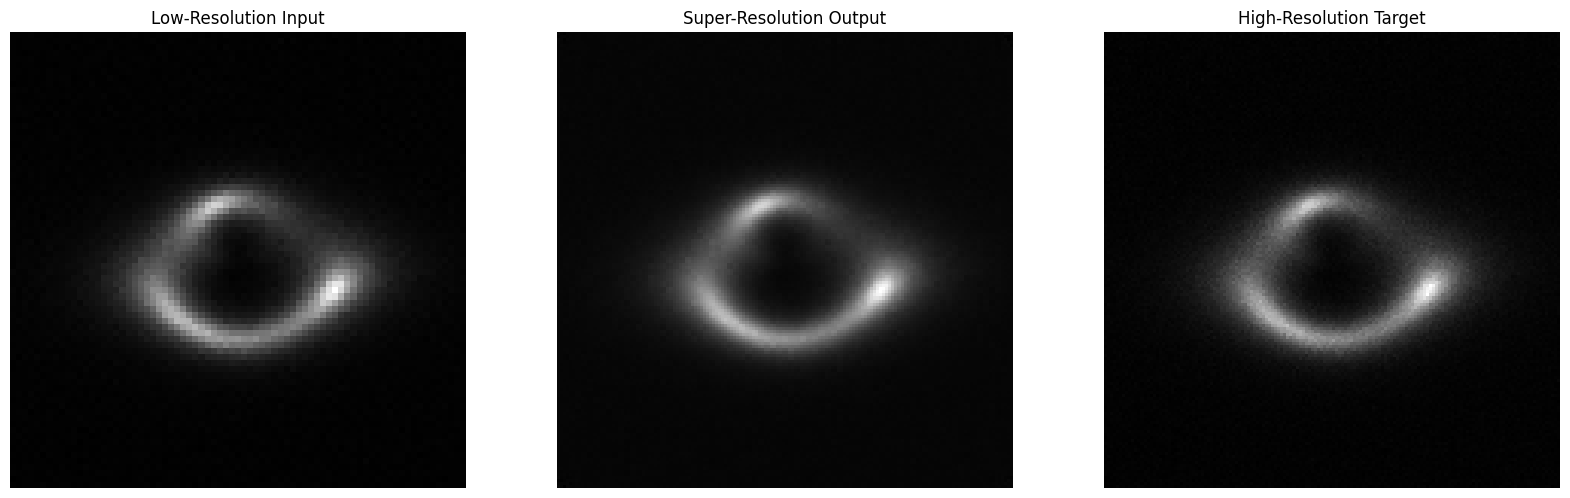

In [21]:
model.eval()  # Set the model to evaluation mode

# Get one batch from your DataLoader
data_iter = iter(test_dataloader)
data = next(data_iter)

# Assuming the batch contains 'lr' and 'hr' keys
lr, hr = data['lr'], data['hr']
lr, hr = lr.to(device), hr.to(device)

# Forward pass through the model
with torch.no_grad():
    sr = model(lr)  # 'sr' stands for super-resolution or model output

# Convert the tensors to NumPy arrays for visualization
# Assuming single-channel grayscale images, adjust accordingly if you have RGB images
lr_np = lr.cpu().squeeze().numpy()
hr_np = hr.cpu().squeeze().numpy()
sr_np = sr.cpu().squeeze().numpy()

visualize_images(lr_np[0], sr_np[0], hr_np[0])

In [ ]:
image_LR = np.load('3B/LR/LR_1.npy')
image_HR = np.load('3B/HR/HR_1.npy')
print(image_LR.shape)
print(image_HR.shape)

GAN-Based models that are designed to generate high-quality images from low-resolution inputs. These models leverage the power of adversarial training to produce visually appealing results with enhanced details and realism. By incorporating a generator and discriminator network, GAN-based super-resolution models can learn to generate high-resolution images that are indistinguishable from real HR images.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * upscale_factor ** 2, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class Generator(nn.Module):
    def __init__(self, n_residual_blocks, num_channels=3):
        super(Generator, self).__init__()
        self.input_conv = nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(n_residual_blocks)]
        )
        self.output_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)
        # For 2x super-resolution, only one UpsampleBLock is needed
        self.upsample_block = UpsampleBLock(64, 2)  # Changed to a single layer, assuming a 2x upsample
        self.final_conv = nn.Conv2d(64, num_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.prelu(x)
        residual = x
        x = self.residual_blocks(x)
        x = self.output_conv(x)
        x = self.bn(x)
        x = x + residual  # Element-wise sum
        x = self.upsample_block(x)  # Adjusted to use the single upsample block
        x = self.final_conv(x)
        return x


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: 3 x 96 x 96
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 2: 64 x 96 x 96
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 3: 128 x 48 x 48
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 4: 256 x 24 x 24
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 5: 512 x 12 x 12
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 6: 1024 x 6 x 6
            nn.AdaptiveAvgPool2d(1),
            # Final Layer: 1024 x 1 x 1
            nn.Conv2d(1024, 1, kernel_size=1),
            nn.Sigmoid() # Adding Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        output = self.net(x)
        return output.view(-1)



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
from torch.utils.data import DataLoader


# Initialize the Generator and Discriminator
generator = Generator(n_residual_blocks=16, num_channels=1).to(device)
discriminator = Discriminator().to(device)

# Wrap the models with nn.DataParallel
if torch.cuda.device_count() > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Content (Pixel-wise) Loss
content_criterion = nn.MSELoss().to(device)

# Adversarial Loss
adversarial_criterion = nn.BCEWithLogitsLoss().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

# Load the pre-trained VGG19 model
vgg = vgg19(weights='DEFAULT').features.to(device).eval()

# Disable gradients for VGG model
for parameter in vgg.parameters():
    parameter.requires_grad = False

# Define the perceptual loss
def perceptual_loss(fake_high_res, real_high_res):
    # Repeat the grayscale image three times to mimic RGB channels
    fake_high_res_rgb = fake_high_res.repeat(1, 3, 1, 1)
    real_high_res_rgb = real_high_res.repeat(1, 3, 1, 1)
    
    # Use VGG to extract features
    fake_features = vgg(fake_high_res_rgb)
    real_features = vgg(real_high_res_rgb)
    
    # Compute MSE loss between feature representations
    return nn.MSELoss()(fake_features, real_features)


def train_srgan(generator, discriminator, train_loader, epochs=30):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'content_loss': 0, 'adversarial_loss': 0}

        for batch_num, data in enumerate(train_loader):
            real_high_res = data['hr'].to(device)
            real_low_res = data['lr'].to(device)
            batch_size = real_high_res.size(0)
            running_results['batch_sizes'] += batch_size

            #####################################
            # Train the Discriminator
            #####################################
            d_optimizer.zero_grad()
            real_output = discriminator(real_high_res)
            fake_high_res = generator(real_low_res).detach()
            fake_output = discriminator(fake_high_res)
            d_loss_real = adversarial_criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = adversarial_criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            d_optimizer.step()
            running_results['d_loss'] += d_loss.item() * batch_size

            #####################################
            # Train the Generator
            #####################################
            g_optimizer.zero_grad()
            fake_high_res = generator(real_low_res)
            fake_output = discriminator(fake_high_res)
            content_loss = perceptual_loss(fake_high_res, real_high_res)
            adversarial_loss = adversarial_criterion(fake_output, torch.ones_like(fake_output))
            g_loss = content_loss + 0.001 * adversarial_loss
            g_loss.backward()
            g_optimizer.step()
            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['content_loss'] += content_loss.item() * batch_size
            running_results['adversarial_loss'] += adversarial_loss.item() * batch_size

        # Print epoch-wise average training details
        print(f"Epoch: [{epoch+1}/{epochs}], Average D Loss: {running_results['d_loss'] / running_results['batch_sizes']:.4f}, "
              f"Average G Loss: {running_results['g_loss'] / running_results['batch_sizes']:.4f}, "
              f"Average Content Loss: {running_results['content_loss'] / running_results['batch_sizes']:.4f}, "
              f"Average Adversarial Loss: {running_results['adversarial_loss'] / running_results['batch_sizes']:.4f}")

    print("Training complete.")

In [17]:
train_srgan(generator, discriminator, train_dataloader)

Epoch: [1/30], Average D Loss: 0.5449, Average G Loss: 0.0918, Average Content Loss: 0.0912, Average Adversarial Loss: 0.6532
Epoch: [2/30], Average D Loss: 0.5101, Average G Loss: 0.0176, Average Content Loss: 0.0170, Average Adversarial Loss: 0.6862
Epoch: [3/30], Average D Loss: 0.5061, Average G Loss: 0.0115, Average Content Loss: 0.0108, Average Adversarial Loss: 0.6903
Epoch: [4/30], Average D Loss: 0.5049, Average G Loss: 0.0107, Average Content Loss: 0.0100, Average Adversarial Loss: 0.6914
Epoch: [5/30], Average D Loss: 0.5044, Average G Loss: 0.0121, Average Content Loss: 0.0114, Average Adversarial Loss: 0.6919
Epoch: [6/30], Average D Loss: 0.5040, Average G Loss: 0.0078, Average Content Loss: 0.0071, Average Adversarial Loss: 0.6924
Epoch: [7/30], Average D Loss: 0.5038, Average G Loss: 0.0070, Average Content Loss: 0.0063, Average Adversarial Loss: 0.6925
Epoch: [8/30], Average D Loss: 0.5037, Average G Loss: 0.0065, Average Content Loss: 0.0058, Average Adversarial Loss:

In [18]:
!nvidia-smi

Sun Mar 24 13:34:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |  11617MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
# save the model generator and discriminator 
torch.save(generator.state_dict(), '/kaggle/working/generator.pth')
torch.save(discriminator.state_dict(), '/kaggle/working/discriminator.pth')

In [26]:
eval_model(generator, test_dataloader, device)

Average PSNR: 30.7365, Average SSIM: 0.7369


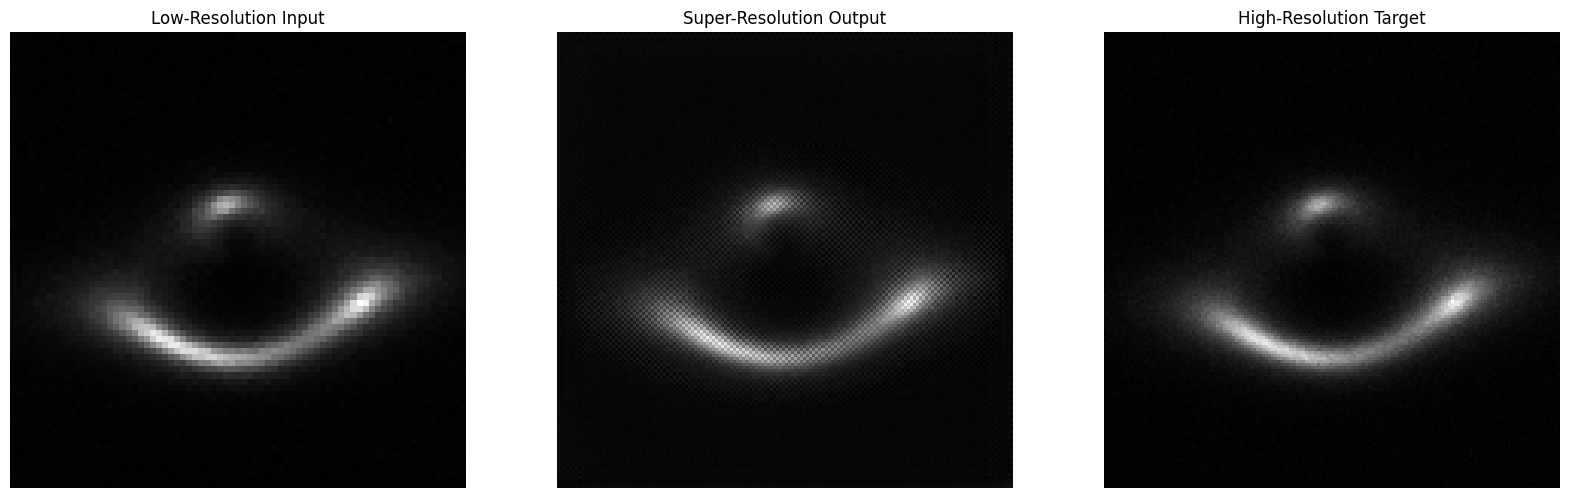

In [28]:
generator.eval()  # Set the model to evaluation mode

# Get one batch from your DataLoader
data_iter = iter(test_dataloader)
data = next(data_iter)

# Assuming the batch contains 'lr' and 'hr' keys
lr, hr = data['lr'], data['hr']
lr, hr = lr.to(device), hr.to(device)

# Forward pass through the model
with torch.no_grad():
    sr = generator(lr)  # 'sr' stands for super-resolution or model output

# Convert the tensors to NumPy arrays for visualization
# Assuming single-channel grayscale images, adjust accordingly if you have RGB images
lr_np = lr.cpu().squeeze().numpy()
hr_np = hr.cpu().squeeze().numpy()
sr_np = sr.cpu().squeeze().numpy()

visualize_images(lr_np[0], sr_np[0], hr_np[0])